In [200]:
import glob
import os
import json
import torch
import pandas as pd

from utils import *

def parse_gradients(gradients):
    df_gradients = pd.DataFrame()
    for i in range(len(gradients)):
        for j in range(len(gradients[i])):
            df_gradients = pd.concat([df_gradients, pd.DataFrame({"round": [i], "layer": [j], "name": [gradients[i][j][0]], "value": [gradients[i][j][1]]})], ignore_index=True)
    # save the dataframe to a csv file  
    # split value into wheter it contains weights or biases
    df_gradients["type"] = df_gradients["name"].apply(lambda x: "weights" if "weight" in x else "biases")
    df_gradients["component"] = df_gradients["name"].apply(lambda x: x.split(".")[0])
    # layer add 1 and then if not devisable by 2 remove 1
    #df_gradients["layer"] = df_gradients["layer"]+1
    df_gradients["layer"] = df_gradients["layer"].apply(lambda x: x if x % 2 == 0 else x - 1)
    df_gradients["layer"] = df_gradients["layer"].apply(lambda x: x // 2 + 1)
    return df_gradients
def print_shapes(w):
    for i in range(len(w)):
        print(f"Layer {i}: {w[i].shape}")

# separate weigts and biases
def separate_weights(w):
    weights = []
    biases = []
    for i in range(len(w)):
        if(len(w[i].shape) == 2):
            weights.append(w[i])
        elif(len(w[i].shape) == 1):
            biases.append(w[i])
    return weights, biases


def load_weigths(df, round):
    w_name = df["weights"][round]
    w_file = glob.glob(f"{fed_avg}/../{w_name}", recursive=True)
    return torch.load(w_file[0])

def total_l2_norm(w0, w1):
    """Returns total L2 norm over all parameters."""
    diffs = [(torch.tensor(a) - torch.tensor(b)).flatten() for a, b in zip(w0, w1)]
    total_diff = torch.cat(diffs)
    return torch.norm(total_diff).item()

def l2norm_perlayer(w0, w1):
    """Returns L2 norm per layer."""
    diffs = [(torch.tensor(a) - torch.tensor(b)).flatten() for a, b in zip(w0, w1)]
    total_diff = torch.cat(diffs)
    return [torch.norm(diff).item() for diff in diffs]

# for each round, compute the l2 norm of the weights between current and previous
def compute_l2_norm_between_rounds(df, round, separate=False, per_layer=False):
    if round == 0:
        if per_layer:
            return [0] * (len(df["weights"][round])-2)
        else:
            return 0
    else:
        if separate:
            w0, _ = separate_weights(load_weigths(df, round-1))
            w1, _ = separate_weights(load_weigths(df, round))
        else:
            w0 = load_weigths(df, round-1)
            w1 = load_weigths(df, round)

        if per_layer:
            diffs = [(torch.tensor(a) - torch.tensor(b)) for a, b in zip(w0, w1)]
            return [torch.norm(diff).item() for diff in diffs]
        else:
            diffs = [(torch.tensor(a) - torch.tensor(b)).flatten() for a, b in zip(w0, w1)]
            total_diff = torch.cat(diffs)
            return torch.norm(total_diff).item()



In [201]:
# get FedAvg and check it is learning
fed_avg = glob.glob(f"../results/periodic/**/FedAvg/**/federated_outputs", recursive=True)
fed_avg = fed_avg[0]
fed_avg

# Input 
cn = 0 
results = glob.glob(f"{fed_avg}/results_{cn}.json", recursive=True)[0]
results

'../results/periodic/federated_training/FedAvg/25_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32_clipping_False_lrdecay_0.01/federated_outputs/results_0.json'

In [202]:
with open(results, "r") as f:
    data = json.load(f)
# extract rounds and weights and put in a dataframe
rounds = []
weights = []
gradients = []
for i in range(len(data["client_train"])):
    rounds.append(data["client_train"][i]["round"])
    weights.append(data["client_train"][i]["weights"])
    gradients.append(data["client_train"][i]["grad_norms"])
df_fedavg = pd.DataFrame({"round": rounds, "weights": weights})
# parse the gradients
df_gradients = parse_gradients(gradients)

# add the gradients to the dataframe

# # compute the l2 norm for each round
l2_norms_weights = []
layer_l2_norms_weights = []
for i in range(len(df_fedavg)):
    l2_norms_weights.append(compute_l2_norm_between_rounds(df_fedavg, i, separate = True, per_layer=False))
    layer_l2_norms_weights.append(compute_l2_norm_between_rounds(df_fedavg, i, separate = True, per_layer=True))

# add the l2 norm to the dataframe
df_fedavg["l2_weights_precedentround"] = l2_norms_weights
df_fedavg["l2_weights_per_layer"] = layer_l2_norms_weights

# df_fedavg_grad = pd.merge(df_fedavg, df_gradients, on="round", how="outer")
df_fedavg

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_50477/2596598031.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


,round,weights,l2_weights_precedentround,l2_weights_per_layer
0,0,weights_237718.pt,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,weights_990689.pt,0.794080,"[0.2427835464477539, 0.1514076590538025, 0.165..."
2,2,weights_46582.pt,0.548624,"[0.16958650946617126, 0.1183425709605217, 0.11..."
3,3,weights_981248.pt,0.533915,"[0.158858522772789, 0.10472824424505234, 0.153..."
4,4,weights_361324.pt,0.479489,"[0.13040800392627716, 0.09098120778799057, 0.1..."
5,5,weights_206331.pt,0.495401,"[0.12971502542495728, 0.11069780588150024, 0.1..."
6,6,weights_83263.pt,0.499584,"[0.13300691545009613, 0.12192562967538834, 0.1..."
7,7,weights_466005.pt,0.501102,"[0.12652873992919922, 0.08872998505830765, 0.1..."
8,8,weights_697470.pt,0.570303,"[0.10670610517263412, 0.08621796220541, 0.1103..."
9,9,weights_833816.pt,0.712596,"[0.14789451658725739, 0.12882384657859802, 0.1..."


In [203]:
len(df_fedavg["l2_weights_per_layer"][0])

15

In [ ]:
weigths = load_weigths(df_fedavg, 0)


/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_50477/2596598031.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


<function len(obj, /)>

In [236]:
for i in range(len(weigths)):
    if len(weigths[i].shape) == 2:
        # reverse the shape
        print(f"Layer {i} (weights): {weigths[i].shape[::-1]}")


Layer 0 (weights): (42, 100)
Layer 2 (weights): (100, 20)
Layer 4 (weights): (42, 100)
Layer 6 (weights): (100, 20)
Layer 8 (weights): (42, 100)
Layer 10 (weights): (100, 40)
Layer 12 (weights): (20, 100)
Layer 14 (weights): (100, 100)
Layer 16 (weights): (100, 20)
Layer 18 (weights): (40, 100)
Layer 20 (weights): (100, 20)
Layer 22 (weights): (10, 100)
Layer 24 (weights): (100, 100)
Layer 26 (weights): (100, 10)
Layer 28 (weights): (10, 1)


In [205]:
# Step 1: Explode and add layer_id
df_weights = df_fedavg[["round", "l2_weights_per_layer"]].explode("l2_weights_per_layer")
df_weights["layer_id"] = df_weights.groupby("round").cumcount()
df_weights["round"] = df_weights["round"] + 1

# Step 2: Get all layer sizes per round
layer_sizes_all_rounds = []
for i in range(len(df_fedavg)):  # one per round
    w = load_weigths(df_fedavg,i)
    weights, _ = separate_weights(w)
    layer_sizes_all_rounds.extend([w.shape for w in weights])  # flat list

# Step 3: Add to exploded dataframe
df_weights["layer_size"] = layer_sizes_all_rounds

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_50477/2596598031.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


In [221]:
w = df_fedavg["weights"][0]
# load weights
weigths = load_weigths(df_fedavg, 3)
weights 

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_50477/2596598031.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


[array([[ 0.00278842,  0.11355004,  0.01691541, ..., -0.01870287,
         -0.1872172 , -0.05008374],
        [-0.01870961,  0.00600097,  0.10198197, ..., -0.04305391,
          0.12121999, -0.11431171],
        [-0.07312125, -0.00146675, -0.02571287, ...,  0.02394772,
         -0.07136932,  0.01891684],
        ...,
        [-0.0130013 ,  0.14793387, -0.10349835, ...,  0.06990096,
          0.12770085, -0.00855308],
        [-0.19692403,  0.02351595,  0.19392353, ...,  0.08711342,
          0.22217843,  0.04472296],
        [-0.06227311,  0.02783273, -0.17025906, ...,  0.02905492,
          0.04187044,  0.05673386]], dtype=float32),
 array([[-0.18159515,  0.16284965, -0.06032278, ..., -0.14095351,
         -0.09032656,  0.06265304],
        [-0.17539683,  0.12059624, -0.00361251, ...,  0.21875842,
          0.038159  , -0.05307654],
        [-0.20498848,  0.11962233, -0.03105128, ...,  0.19331695,
         -0.00574216,  0.17391722],
        ...,
        [-0.10081366, -0.07116199, -0.0

In [206]:
df_weights["size"] = df_weights["layer_size"].apply(lambda x: x[0] * x[1] if len(x) == 2 else x[0])
df_weights["layer_size"] = df_weights["layer_size"].apply(lambda x: f"{x[0]}x{x[1]}" if len(x) == 2 else str(x[0]))
df_weights["l2_weights_per_layer"] = df_weights["l2_weights_per_layer"].astype(float)
df_weights["size"] = df_weights["size"].astype(float)
# normalize the l2 norm
df_weights["norm_l2_weights_per_layer"] = df_weights["l2_weights_per_layer"] / df_weights["size"]



In [207]:
df_weights

,round,l2_weights_per_layer,layer_id,layer_size,size,norm_l2_weights_per_layer
0,1,0.000000,0,100x42,4200.0,0.000000
0,1,0.000000,1,20x100,2000.0,0.000000
0,1,0.000000,2,100x42,4200.0,0.000000
0,1,0.000000,3,20x100,2000.0,0.000000
0,1,0.000000,4,100x42,4200.0,0.000000
...,...,...,...,...,...,...
24,25,0.163183,10,20x100,2000.0,0.000082
24,25,0.086477,11,100x10,1000.0,0.000086
24,25,0.280950,12,100x100,10000.0,0.000028
24,25,0.079205,13,10x100,1000.0,0.000079


<Figure size 600x400 with 0 Axes>

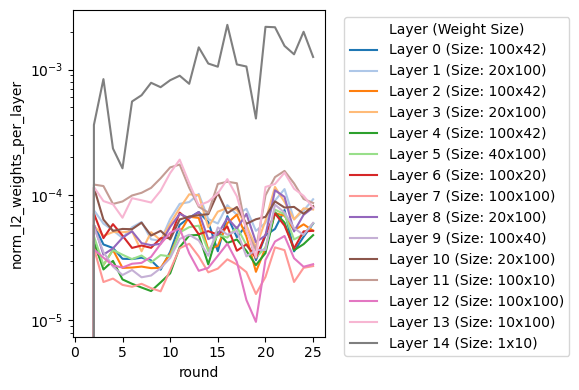

In [208]:
# plot l2_weitghs per layer vs round
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))



plt.figure(figsize=(6, 4))

num_layers = df_weights["layer_id"].nunique()
palette = sns.color_palette("tab20", num_layers)

ax = sns.lineplot(
    data=df_weights,
    x="round",
    y="norm_l2_weights_per_layer",
    hue="layer_id",
    palette=palette
)

# Build custom legend labels with layer sizes
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
    layer_id = int(label)
    # Get the first layer_size value for this layer_id (assuming consistent shape)
    size = df_weights[df_weights["layer_id"] == layer_id]["layer_size"].iloc[0]
    # Format the size tuple nicely
    size_str = "x".join(map(str, size)) if isinstance(size, (tuple, list)) else str(size)
    new_labels.append(f"Layer {layer_id} (Size: {size_str})")

# Update legend with new labels
ax.legend(handles=handles, labels=new_labels, title="Layer (Weight Size)", bbox_to_anchor=(1.05, 1), loc='upper left')
# y log
ax.set_yscale('log')
plt.tight_layout()
plt.show()



